In [1]:
from flyingpigeon import weatherregimes as wr
from flyingpigeon import utils
from os import listdir, path ,getenv

HOME = getenv('HOME')

In [2]:
from flyingpigeon.visualisation import plot_kMEAN, plot_pressuremap, concat_images
from IPython.display import Image
from numpy import ma, mean

In [3]:
#p = HOME + '/.conda/envs/birdhouse/var/lib/cache/pywps/www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface'
#observation = [path.join(p,f) for f in listdir(p)]
# or simply run:
observation = wr.get_NCEP()

p = HOME+'/.conda/envs/birdhouse/var/lib/cache/pywps/esgf1.dkrz.de/thredds/fileServer/cmip5/cmip5/output1/MPI-M/MPI-ESM-LR/historical/day/atmos/day/r1i1p1/v20111006/psl'
model = [path.join(p,f) for f in listdir(p)]

In [4]:
len(observation)

69

In [ ]:
nc_obs = wr.subset(observation, bbox="-80,50,22.5,70", time_region='12,1,2')

In [19]:
nc_model = wr.subset(model, bbox="-80,50,22.5,70", time_region='12,1,2', regrid_destination=nc_obs)

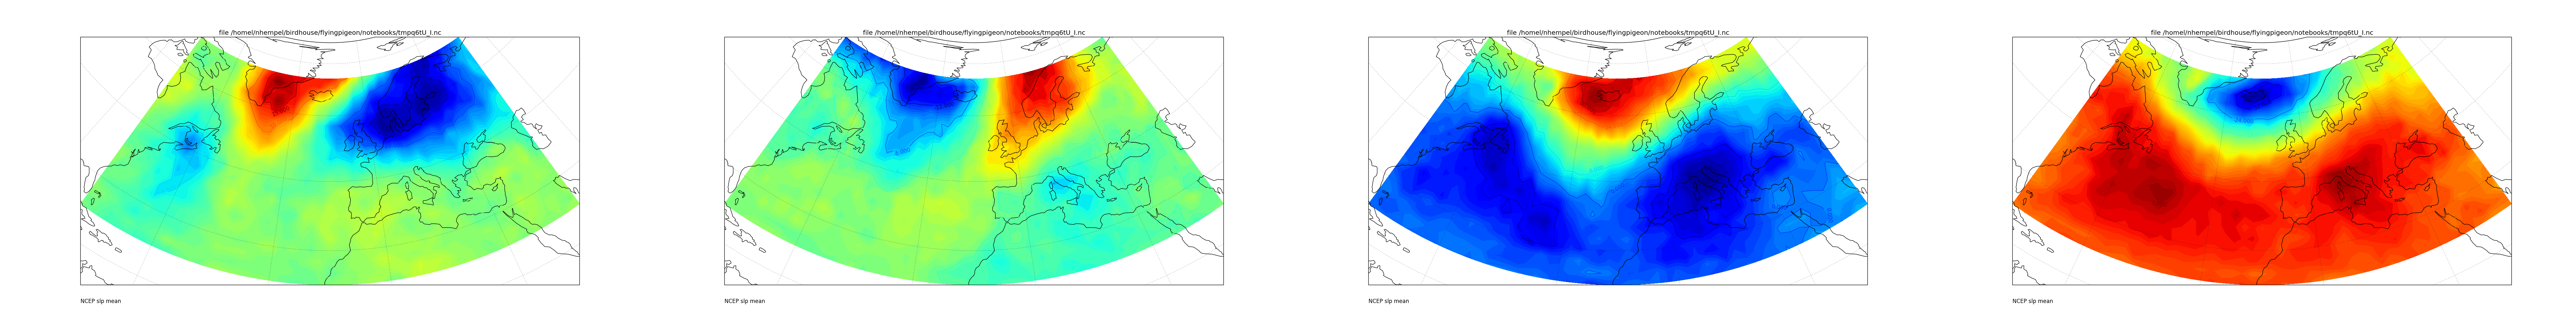

In [20]:
file = nc_obs
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

subplots = []
obs_pattern = []
for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    obs_pattern.append(pattern)
    subplots.append(plot_pressuremap(pattern, 
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='NCEP slp mean'))
#    regime_dic['NCEP']['weather regime %s' % i] = mean(data_ncep[best_pattern], axis = 0)

con = concat_images(subplots, orientation='h')
Image(filename=con)

variable name: psl


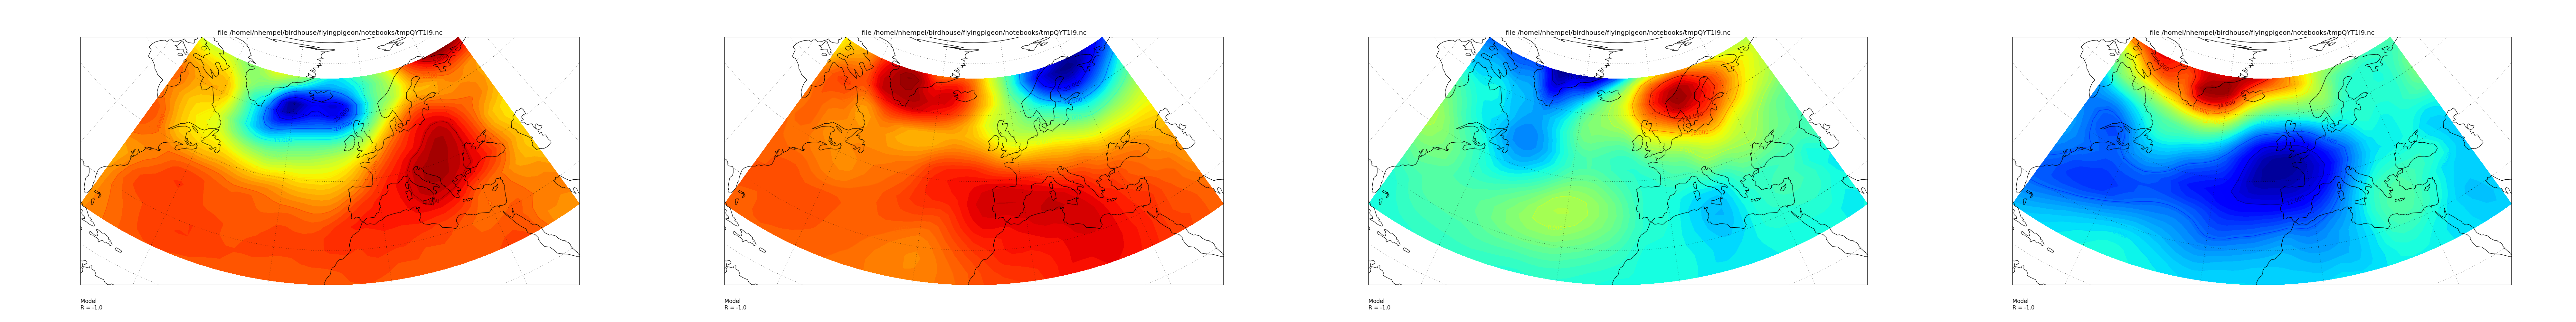

In [57]:
file = nc_model
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

import numpy as np 
from scipy import stats

subplots = []
model_pattern = []
stat_vals = np.ones([4, 5]) * -1 
r_vals = np.ones([4]) * -1
order = np.ones([4]) * -1
m, n  = obs_pattern[0].shape

for i in [0,1,2,3]:
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    model_pattern.append(pattern)
    
    #### compare with observation    
    for j in [0,1,2,3]:
        p = -1
        r_value = 0
        x = np.reshape(model_pattern[i], (n*m))
        y = np.reshape(obs_pattern[j], (n*m))
        alpha, beta, r_value, p_value, std_err = stats.linregress(x, y)
        # print 'model',i , 'obs', j
        if r_vals[i] <= r_value: #r_value >= stat_vals[j][2]:    
            r_vals[i] = r_value
            #stat_vals[i,:] = [alpha, beta, r_value, p_value, std_err]
            order[j] = i
        
    subplots.append(plot_pressuremap(pattern,
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='Model \nR = %s \n' % stat_vals[i,:][2] ))

con = concat_images(subplots, orientation='h')
Image(filename=con)

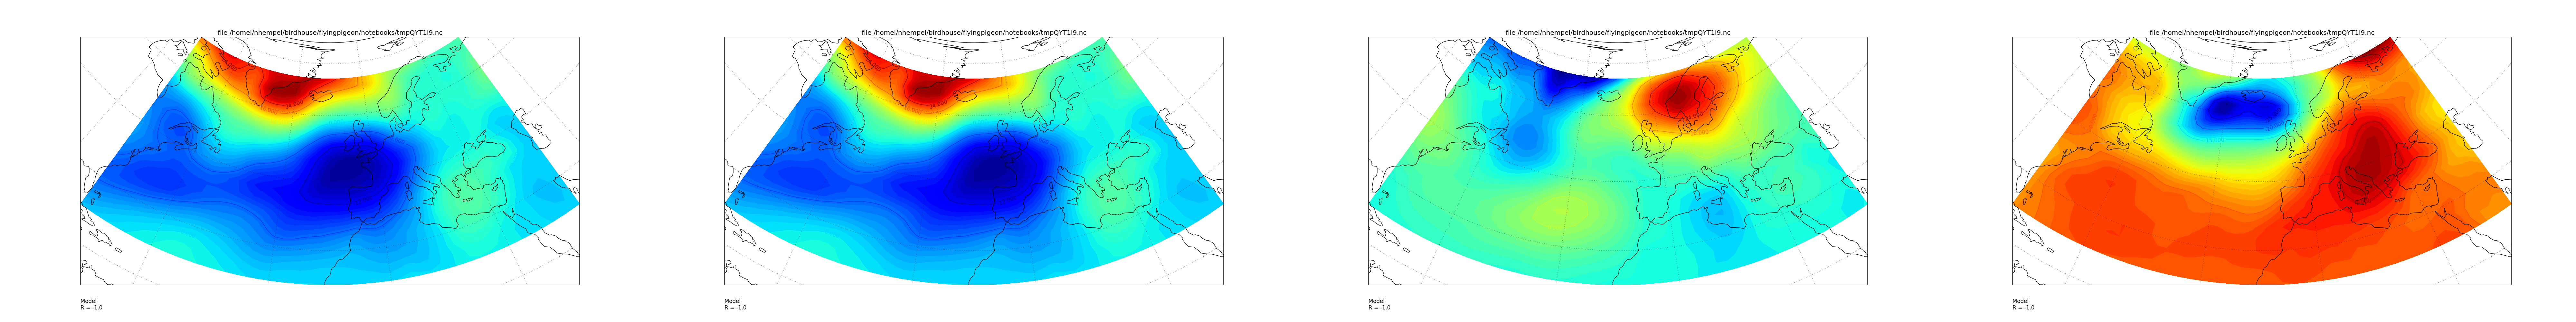

In [58]:
subplots_ordered = [subplots[int(i)] for i in order]
con = concat_images(subplots_ordered, orientation='h')
Image(filename=con)